In [4]:
%load_ext autoreload
%autoreload 2
import innvestigate
import tensorflow as tf
from pathlib import Path
import xarray as xr
from hmpai.training import split_data_on_participants, train_and_evaluate
from hmpai.normalization import *
from hmpai.generators import SAT1DataGenerator
from hmpai.utilities import set_global_seed
import matplotlib.pyplot as plt
import numpy as np
from hmpai.data import SAT1_STAGES_ACCURACY, preprocess
tf.compat.v1.disable_eager_execution()
from mne.viz import plot_topomap
from mne.io import read_info
from collections import defaultdict
import random
from hmpai.visualization import add_analysis, plot_max_activation_per_label, plot_single_trial_activation, plot_mean_activation_per_label
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env TF_GPU_ALLOCATOR=cuda_malloc_async

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [5]:
data_path = Path("../data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)
set_global_seed(42)
train_data, val_data, test_data = split_data_on_participants(data, 60, norm_dummy)

In [6]:
positions = read_info(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))

In [10]:
model = tf.keras.models.load_model("models/cnn_base_test")


def model_modifier(model):
    model.layers[-1].activation = tf.keras.activations.linear


model_modifier(model)
analyzer = innvestigate.create_analyzer(
    "lrp.sequential_preset_a_flat", model, epsilon=1
)
# analyzer = innvestigate.create_analyzer("smoothgrad", model)

2023-10-22 11:15:40.416409: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_37' id:772 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_37}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](count_3, Identity_37)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [11]:
# Batch-wise analysing of all test set samples
test_set = add_analysis(test_data, analyzer)

2023-10-22 11:15:44.261219: W tensorflow/c/c_api.cc:304] Operation '{name:'bias_11/Assign' id:1041 op device:{requested: '', assigned: ''} def:{{{node bias_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_11, bias_11/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-10-22 11:15:44.552398: W tensorflow/c/c_api.cc:304] Operation '{name:'gradients_12/MaxNeuronSelection/Max_grad/range' id:1213 op device:{requested: '', assigned: ''} def:{{{node gradients_12/MaxNeuronSelection/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection/Max"], _has_manual_control_dependencies=true](gradients_12/MaxNeuronSelection/Max_grad/range/start, gradients_12/MaxNeuronSelection/Max_grad/Size, gradients_12/MaxNeuronSelection/Max_grad/range/delta

### Max model attention sample
Take sample where mean activation (over channels) is maximal, take the mean of that over samples to get mean max activation per label

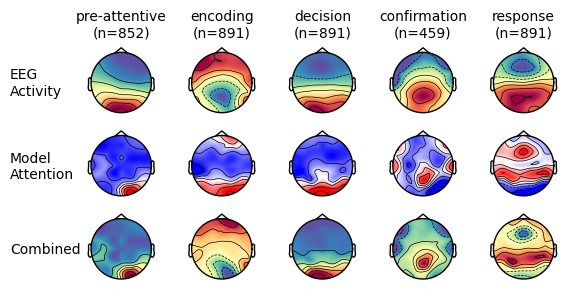

In [7]:
plot_max_activation_per_label(test_set, positions)

In [7]:
# Show mean activation on y-axis, samples/time on x, at intervals (10 samples?) 10% of squished sample size?

### Per-trial EEG activity, model attention, combined

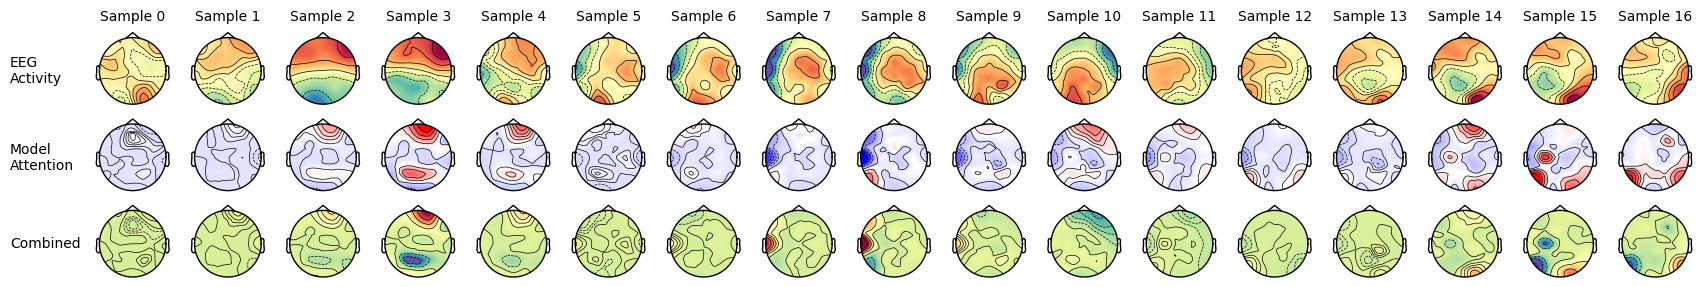

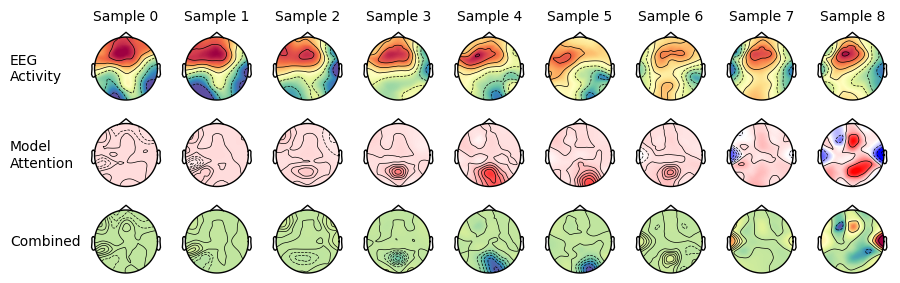

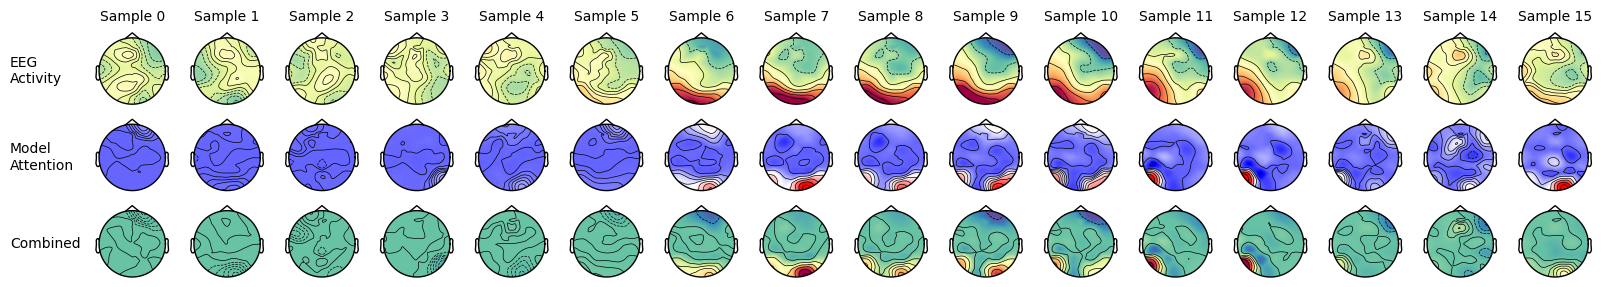

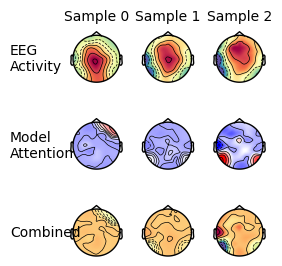

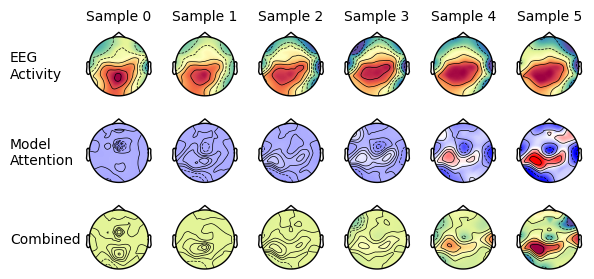

In [15]:
for i in range(10, 15):
    plot_single_trial_activation(test_set.isel(index=i), positions)

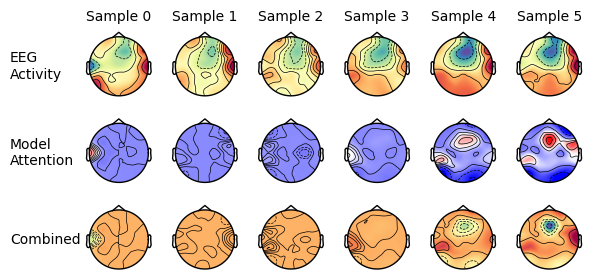

In [36]:
sample = test_set.isel(index=4)
plot_single_trial_activation(sample, positions)

#### Mean activation per label

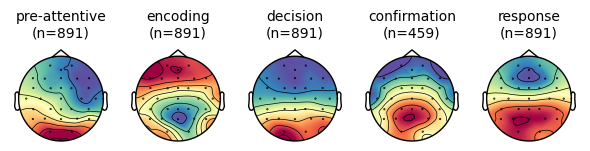

In [19]:
test_data_preprocessed = preprocess(test_data)
plot_mean_activation_per_label(test_data_preprocessed, positions)

### Model attention over stage duration (%)
Shows which part of the processing stage the model is most attentive towards

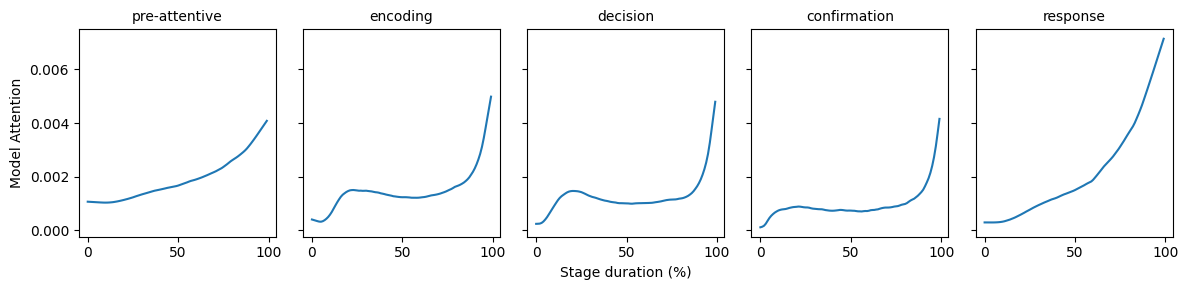

In [7]:
f, ax = plt.subplots(
    nrows=1, ncols=len(SAT1_STAGES_ACCURACY), figsize=(12, 3), sharey=True, sharex=True
)

time_points = np.linspace(0, 100, 100)
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    subset = test_set.sel(labels=label)
    nan_indices = np.isnan(subset.analysis.where(subset.analysis != 0)).argmax(
        dim=["samples", "channels"]
    )
    interpolated = []
    for sample, nan_index in zip(subset.analysis, nan_indices["samples"]):
        sequence = sample.mean(dim="channels")[0 : nan_index.item()]
        if len(sequence) == 0:
            continue
        origin_time_points = np.linspace(0, 100, num=len(sequence))
        interpolated_sequence = np.interp(time_points, origin_time_points, sequence)
        interpolated.append(interpolated_sequence)
    ax[i].plot(np.mean(interpolated, axis=0))
    ax[i].set_title(f"{label}", fontsize=10)
# ax[2].text(0, -0.005, 'Linear interpolation\nof stage length', va='bottom', ha='center')
ax[0].set_ylabel("Model Attention")
ax[2].set_xlabel("Stage duration (%)")
plt.tight_layout()
plt.show()

### Deprecated

In [ ]:
test_gen = SAT1DataGenerator(test_data)
test_items = defaultdict(list)
results = defaultdict(list)
results_combined = defaultdict(list)
for batch_idx in range(len(test_gen)):
    test_batch = test_gen.__getitem__(batch_idx)
    for item in test_batch[0]:
        # (154, 30) test sample
        item_label = item.labels.item()
        item_reshaped = item.data.reshape((1, 154, 30, 1))
        # Back to (154, 30)
        analysis = np.squeeze(analyzer.analyze(item_reshaped))
        # analysis /= np.max(np.abs(analysis))
        # Get max activation sample
        max_sample_idx = np.argmax(np.sum(analysis, axis=1))
        max_activation_sample = analysis[max_sample_idx, :]
        max_activity = max_activation_sample * item[max_sample_idx, :]
        test_items[item_label].append(item[max_sample_idx, :])
        results[item_label].append(max_activation_sample)
        results_combined[item_label].append(max_activity)
        # Get mean activation
        # analysis[analysis == 0] = np.nan
        # item.data[item.data == 999] = np.nan
        # mean_activation = np.nanmean(analysis, axis=0)
        # mean_activity = np.nanmean(item.data, axis=0)
        # results[item_label].append(mean_activation)
        # test_items[item_label].append(mean_activity)
        # results_combined[item_label].append(mean_activation * mean_activity)

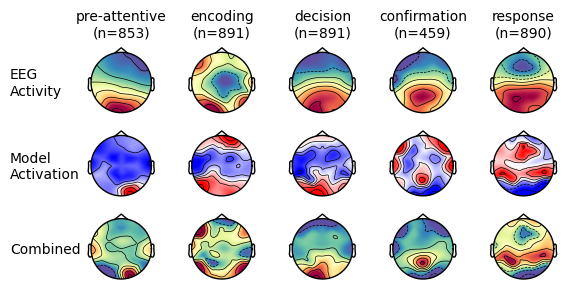

In [6]:
f, ax = plt.subplots(nrows=3, ncols=len(SAT1_STAGES_ACCURACY), figsize=(6, 3))

for i, label in enumerate(SAT1_STAGES_ACCURACY):
    label_results = np.array(test_items[label])
    n = len(test_items[label])
    mean_eeg_activity = np.mean(label_results, axis=0)
    ax[0, i].set_title(f"{label}\n(n={n})", fontsize=10)

    # Row titles
    if i == 0:
        ax[0, i].text(-0.35, 0, "EEG\nActivity", va="center", ha="left")
        ax[1, i].text(-0.35, 0, "Model\nActivation", va="center", ha="left")
        ax[2, i].text(-0.35, 0, "Combined", va="center", ha="left")
    # Raw EEG Activation
    plot_topomap(
        mean_eeg_activity,
        positions,
        axes=ax[0, i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_eeg_activity), np.max(mean_eeg_activity)),
        sensors=False,
        contours=6,
    )
    # Model activity
    label_results = np.array(results[label])
    mean_importance = np.mean(label_results, axis=0)
    plot_topomap(
        mean_importance,
        positions,
        axes=ax[1, i],
        show=False,
        cmap="bwr",
        vlim=(np.min(mean_importance), np.max(mean_importance)),
        sensors=False,
        contours=6,
    )
    # Combined
    label_results = np.array(results_combined[label])
    mean_combined_importance = np.mean(label_results, axis=0)
    plot_topomap(
        mean_combined_importance,
        positions,
        axes=ax[2, i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_combined_importance), np.max(mean_combined_importance)),
        sensors=False,
        contours=6,
    )
plt.tight_layout()
plt.show()

In [1]:
f, ax = plt.subplots(nrows=1, ncols=len(SAT1_STAGES_ACCURACY), figsize=(6, 4))
mean_importances = np.zeros((len(SAT1_STAGES_ACCURACY), len(data.channels)))
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    # print(k)
    label_results = np.array(results[label])
    print(label_results.shape)
    mean_importance = np.mean(label_results, axis=0)
    mean_importances[i, :] = mean_importance
    # ax[i].set_title(label)
    # plot_topomap(
    #     mean_importance,
    #     positions,
    #     axes=ax[i],
    #     show=False,
    #     cmap="Spectral_r",
    #     vlim=(np.min(mean_importance), np.max(mean_importance)),
    #     sensors=False,
    #     contours=6,
    # )
# Normalized by stage
mean_importances = (mean_importances - np.mean(mean_importances, axis=0)) / np.std(
    mean_importances, axis=0
)
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    ax[i].set_title(label)
    plot_topomap(
        mean_importances[i, :],
        positions,
        axes=ax[i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_importances[i, :]), np.max(mean_importances[i, :])),
        sensors=False,
        contours=6,
    )
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined